In [16]:
#Initial Setup
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
from time import process_time
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('dass.csv')
df.head()

,country,tipi1,tipi2,tipi3,tipi4,tipi5,tipi6,tipi7,tipi8,tipi9,...,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat,dep_cond,anx_cond,str_cond
0,IN,1,5,7,7,7,7,7,5,1,...,No Degree,27,3,34,4,40,4,3 Severe,4 Extremely Severe,4 Extremely Severe
1,US,6,5,4,7,5,4,7,7,1,...,No Degree,24,3,17,3,27,3,3 Severe,3 Severe,3 Severe
2,PL,2,5,2,2,5,6,5,5,3,...,No Degree,39,4,12,2,17,1,4 Extremely Severe,2 Moderate,1 Mild
3,US,1,1,7,4,6,4,6,1,6,...,Biology,16,2,17,3,16,1,2 Moderate,3 Severe,1 Mild
4,MY,2,5,3,6,5,5,5,6,3,...,Psychology,32,4,40,4,29,3,4 Extremely Severe,4 Extremely Severe,3 Severe


In [3]:
# Check datatypes 
df.dtypes.value_counts()

int64      27
object      6
float64     1
dtype: int64

In [4]:
# Change demographic columns to contain numeric data
df['country']=pd.factorize(df['country'], sort=True)[0]+1
df['major']=pd.factorize(df['major'], sort=True)[0]+1

In [5]:
# Drop 'age_group column' (keeping 'age')
# Drop overall score columns and descriptor columns since they are covered by category 
df.drop(['age_group','Depression','Anxiety','Stress','dep_cond','anx_cond','str_cond'],axis=1,inplace=True)

In [6]:
# Confirm they're gone
df.dtypes.value_counts()

int64      26
float64     1
dtype: int64

In [7]:
# Target variable will determine severe depression/anxiety/stress. Levels 3 or 4 indicate severe
# depression/anxiety/stress. So an outcome of 1 means the individual has severe depression/anxiety/
# stress, while 0 means they do not.

# Create binary outcome for Depression
bin_out=[]
for i in df['Depression_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)
df['DOutcome']=bin_out

# Create binary outcome for Anxiety
bin_out=[]
for i in df['Anxiety_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)
df['AOutcome']=bin_out

# Create binary outcome for Stress
bin_out=[]
for i in df['Stress_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)
df['SOutcome']=bin_out

df.head()

,country,tipi1,tipi2,tipi3,tipi4,tipi5,tipi6,tipi7,tipi8,tipi9,...,voted,married,familysize,major,Depression_cat,Anxiety_cat,Stress_cat,DOutcome,AOutcome,SOutcome
0,61,1,5,7,7,7,7,7,5,1,...,2,1,2,46,3,4,4,1,1,1
1,135,6,5,4,7,5,4,7,7,1,...,2,1,4,46,3,3,3,1,1,1
2,105,2,5,2,2,5,6,5,5,3,...,1,1,3,46,4,2,1,1,0,0
3,135,1,1,7,4,6,4,6,1,6,...,2,1,5,10,2,3,1,0,1,0
4,92,2,5,3,6,5,5,5,6,3,...,2,1,4,56,4,4,3,1,1,1


In [8]:
df.drop(['Depression_cat','Anxiety_cat','Stress_cat'],axis=1,inplace=True)

In [9]:
df.head()

,country,tipi1,tipi2,tipi3,tipi4,tipi5,tipi6,tipi7,tipi8,tipi9,...,religion,orientation,race,voted,married,familysize,major,DOutcome,AOutcome,SOutcome
0,61,1,5,7,7,7,7,7,5,1,...,12,1,10,2,1,2,46,1,1,1
1,135,6,5,4,7,5,4,7,7,1,...,7,5,70,2,1,4,46,1,1,1
2,105,2,5,2,2,5,6,5,5,3,...,4,3,60,1,1,3,46,1,0,0
3,135,1,1,7,4,6,4,6,1,6,...,4,5,70,2,1,5,10,0,1,0
4,92,2,5,3,6,5,5,5,6,3,...,10,1,10,2,1,4,56,1,1,1


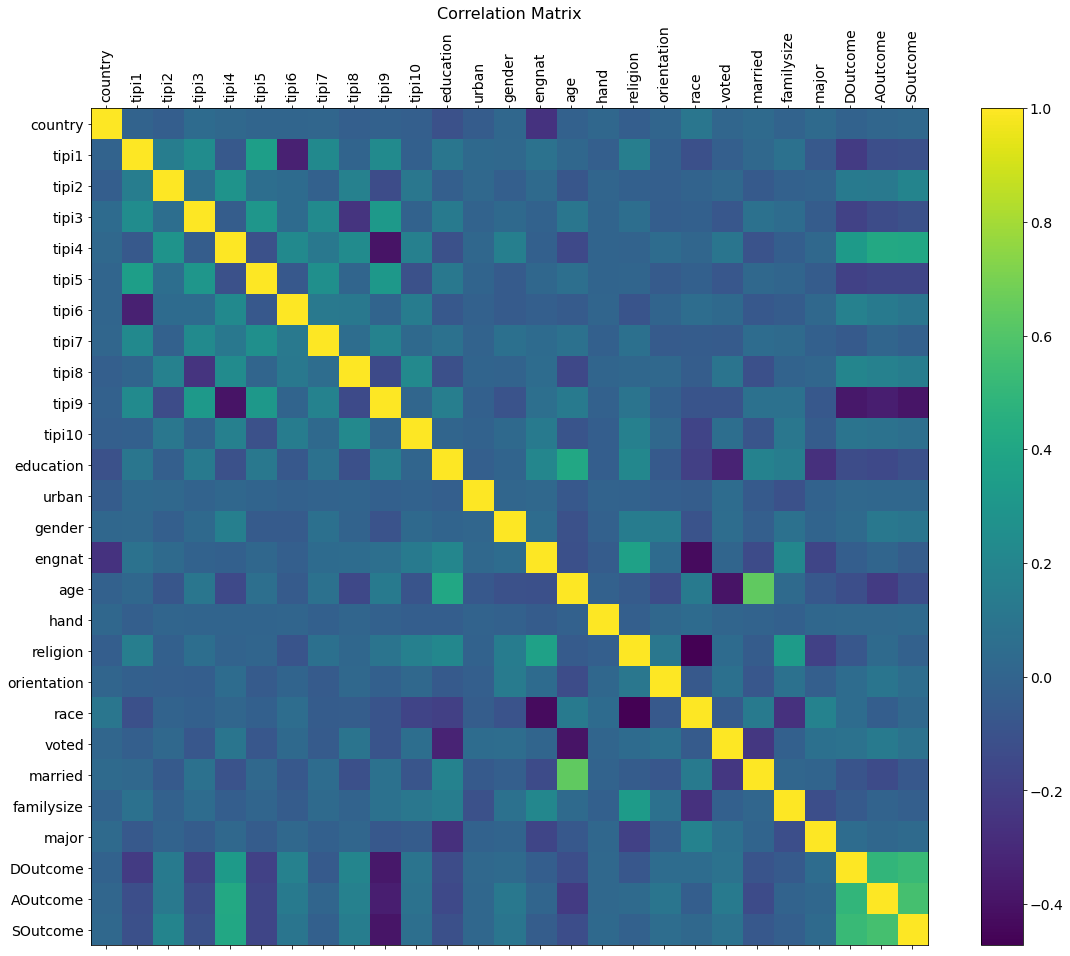

In [10]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Dimensionality Reduction

In [18]:
# Create feature matrix for X
feature_df = df.drop(['DOutcome','AOutcome','SOutcome'], axis=1)
feature_df.head()

,country,tipi1,tipi2,tipi3,tipi4,tipi5,tipi6,tipi7,tipi8,tipi9,...,engnat,age,hand,religion,orientation,race,voted,married,familysize,major
0,61,1,5,7,7,7,7,7,5,1,...,2,16.0,1,12,1,10,2,1,2,46
1,135,6,5,4,7,5,4,7,7,1,...,1,16.0,2,7,5,70,2,1,4,46
2,105,2,5,2,2,5,6,5,5,3,...,2,17.0,1,4,3,60,1,1,3,46
3,135,1,1,7,4,6,4,6,1,6,...,1,13.0,2,4,5,70,2,1,5,10
4,92,2,5,3,6,5,5,5,6,3,...,2,19.0,3,10,1,10,2,1,4,56


In [19]:
#Scale the data
scaler = StandardScaler()
scaled_features=scaler.fit_transform(feature_df)

# Define variables
X = scaled_features
Dy = df['DOutcome'].values.reshape(-1,1)
Ay = df['AOutcome'].values.reshape(-1,1)
Sy = df['SOutcome'].values.reshape(-1,1)

In [ ]:
# Create the pipeline
rfe = RFE(estimator=RandomForestClassifier(n_estimators=500), n_features_to_select=5)
model = RandomForestClassifier(n_estimators=500)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# Evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, Dy, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
#Obtain principal components
pca = PCA().fit_transform(scaled_features)

pc1 = pca[:,0]
pc2 = pca[:,1]

In [ ]:
#Plot principal components for Depression
plt.figure(figsize=(12,10))

colour = ['#ff2121' if y == 1 else '#2176ff' for y in df['DOutcome']]
plt.scatter(pc1,pc2 ,c=colour,edgecolors='#000000')
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
#Plot principal components for Anxiety
plt.figure(figsize=(12,10))

colour = ['#ff2121' if y == 1 else '#2176ff' for y in df['AOutcome']]
plt.scatter(pc1,pc2 ,c=colour,edgecolors='#000000')
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
#Plot principal components for Stress
plt.figure(figsize=(12,10))

colour = ['#ff2121' if y == 1 else '#2176ff' for y in df['SOutcome']]
plt.scatter(pc1,pc2 ,c=colour,edgecolors='#000000')
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:


# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(X)
reduced_ninety_five = pca.transform(X)
no_comp = reduced_ninety_five.shape[1]
no_comp

This shows that 21 components will capture 95% of the variance.  (That's ALL of the features.)

### Oversampling

In [ ]:
# Check balance of Outcomes

#Depression Outcomes
unique, counts = np.unique(Dy, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
#Anxiety Outcomes
unique, counts = np.unique(Ay, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
#Stress Outcomes
unique, counts = np.unique(Sy, return_counts=True)
print(np.asarray((unique, counts)).T)

Depression and Anxiety outcomes are well-balanced, but not Stress.

In [ ]:
# Perform SMOTE on the Stress dataset
resample=SMOTE(random_state=42)

SX_res, Sy_res = resample.fit_resample(X,Sy)

In [ ]:
unique, counts = np.unique(Sy_res, return_counts=True)
print(np.asarray((unique, counts)).T)

### Ensemble Learning

In [ ]:
# Create training and test sets for each condition

#Depression
DX_train, DX_test, Dy_train, Dy_test = train_test_split(X, Dy, test_size=0.2, random_state=42)

#Anxiety
AX_train, AX_test, Ay_train, Ay_test = train_test_split(X, Ay, test_size=0.2, random_state=42)

#Stress
SX_train, SX_test, Sy_train, Sy_test = train_test_split(SX_res, Sy_res, test_size=0.2, random_state=42)

In [ ]:
rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=42) # probability calculation
clf2 = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf)], voting='soft') 
clf2.fit(DX_train, Dy_train.ravel())
Dy_pred = clf2.predict(DX_test)

In [ ]:
print(classification_report(Dy_test,Dy_pred))

In [ ]:
rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=42) # probability calculation
clf2 = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf)], voting='soft') 
clf2.fit(AX_train, Ay_train.ravel())
Ay_pred = clf2.predict(AX_test)
print(classification_report(Ay_test,Ay_pred))

In [ ]:
rfClf = RandomForestClassifier(n_estimators=500, random_state=0) # 500 trees. 
svmClf = SVC(probability=True, random_state=42) # probability calculation
clf2 = VotingClassifier(estimators = [('rf',rfClf), ('svm',svmClf)], voting='soft') 
clf2.fit(SX_train, Sy_train.ravel())
Sy_pred = clf2.predict(SX_test)
print(classification_report(Sy_test,Sy_pred))

In [ ]:
#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 1:
        # Polynomial kernel
        return SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 2:
        # Radial Basis Function kernel
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 3:
        # Sigmoid kernel
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 4:
        # Linear kernel
        return SVC(kernel='linear', gamma="auto")

In [ ]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']

for i in range(1,5):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
    svclassifier = getClassifier(i)
    svclassifier.fit(X_train, y_train.ravel())
    y_pred = svclassifier.predict(X_test)
    print("Evaluation:", kernels[i-1], "kernel")
    print(classification_report(y_test,y_pred))

In [ ]:
# Apply most performative kernel parameter(s) to param_grid
param_grid = {'C': [0.1,1, 10, 100], 'gamma': ['auto'],'kernel': ['rbf','linear']}

In [ ]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train.ravel())

In [ ]:
print(grid.best_estimator_)

In [ ]:
# Apply SVC with optimal parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
svclassifier = SVC(kernel='rbf', gamma="auto", C=0.1)
svclassifier.fit(X_train, y_train.ravel())
y_pred = svclassifier.predict(X_test)

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

In [ ]:
print(classification_report(y_test,y_pred))

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')